In [154]:
import pandas as pd
import numpy as np
import json
import pickle
from pandas.io.json import json_normalize
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
import sys
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot as plt

In [155]:
!{sys.executable} -m pip install xgboost

In [156]:
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot as plt

In [157]:
with open("previous_application.pkl", 'rb') as picklefile: 
    previous_application_df = pickle.load(picklefile)
with open("df_application_v2.pkl", 'rb') as picklefile: 
    df_application_v2 = pickle.load(picklefile)

In [158]:
previous_application_df.columns

Index(['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY',
       'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
       'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY',
       'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY',
       'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE',
       'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE',
       'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE',
       'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY',
       'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL'],
      dtype='object')

In [159]:
previous_application_df[previous_application_df.duplicated(subset="SK_ID_CURR")].head()

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x1157ca828>>
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/site-packages/xgboost/core.py", line 482, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
23,1172937,302212,Cash loans,39475.305,1129500.0,1277104.5,NaN,1129500.0,THURSDAY,5,...,XNA,54.0,low_normal,Cash X-Sell: low,NaN,NaN,NaN,NaN,NaN,NaN
115,2686051,101529,Cash loans,NaN,0.0,0.0,NaN,NaN,TUESDAY,9,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
180,1630059,405785,Consumer loans,4550.535,28300.5,22617.0,6750.0,28300.5,FRIDAY,10,...,Connectivity,6.0,high,POS mobile with interest,365243.0,-2005.0,-1855.0,-1855.0,-1851.0,0.0
217,1129372,203250,Cash loans,31952.205,495000.0,553806.0,NaN,495000.0,THURSDAY,10,...,XNA,36.0,high,Cash X-Sell: high,365243.0,-829.0,221.0,-769.0,-765.0,1.0
262,2562544,163961,Cash loans,29527.200,270000.0,270000.0,0.0,270000.0,WEDNESDAY,12,...,Consumer electronics,12.0,high,Cash Street: high,365243.0,-2307.0,-1977.0,-1977.0,-1969.0,0.0


In [187]:
previous_application_df.rename(columns={"AMT_ANNUITY": "AMT_PREV_ANNUITY", "AMT_CREDIT": "AMT_PREV_CREDIT"}, inplace=True)
previous_application_df["EST_PREV_LOAN_PERIOD"] = previous_application_df["AMT_PREV_CREDIT"] / previous_application_df["AMT_PREV_ANNUITY"]


In [188]:
#previous_application_df.loc[previous_application_df['SK_ID_CURR'] == 187868 ]

**Hypothesis** = The more loans previously issues, higher the chance of default. 
The below feature engineering calculates the total number of loans previously issued for a client, for each current loan applicant. 

In [189]:
num_loans_prev_issued = previous_application_df["SK_ID_CURR"].value_counts().reset_index()

In [190]:
num_loans_prev_issued.rename(index=str, columns={"index":"SK_ID_CURR", "SK_ID_CURR":"NUM_LOANS_PREV_ISSUED"}, inplace=True)

In [191]:
num_loans_prev_issued.sort_values(by="NUM_LOANS_PREV_ISSUED", ascending=False).head(10)

,SK_ID_CURR,NUM_LOANS_PREV_ISSUED
0,187868,77
1,265681,73
2,173680,72
3,242412,68
4,206783,67
5,156367,66
6,389950,64
7,382179,64
8,198355,63
9,345161,62


In [192]:
with open('num_loans_prev_issued.pkl', 'wb') as picklefile:
    pickle.dump(num_loans_prev_issued, picklefile)

In [193]:
# IF this column value is positive, it means the client received LESS amount than the application amount. 
previous_application_df["AMT_APPLIED_VS_AMT_RECEIVED"] = previous_application_df["AMT_APPLICATION"] - previous_application_df["AMT_PREV_CREDIT"]

#### Below DF stores info about the average difference calculated between amount received vs ammount applied for through many loans that a particular client has previously applied for

In [194]:
amt_applied_amt_received_diff  = previous_application_df.groupby(["SK_ID_CURR"])["AMT_APPLIED_VS_AMT_RECEIVED"].mean().reset_index()

In [195]:
with open('amt_applied_amt_received_diff.pkl', 'wb') as picklefile:
    pickle.dump(amt_applied_amt_received_diff, picklefile)

In [196]:
previous_application_df["NAME_GOODS_CATEGORY"].unique()

array(['Mobile', 'XNA', 'Consumer Electronics', 'Construction Materials',
       'Auto Accessories', 'Photo / Cinema Equipment', 'Computers',
       'Audio/Video', 'Medicine', 'Clothing and Accessories', 'Furniture',
       'Sport and Leisure', 'Homewares', 'Gardening', 'Jewelry',
       'Vehicles', 'Education', 'Medical Supplies', 'Other',
       'Direct Sales', 'Office Appliances', 'Fitness', 'Tourism',
       'Insurance', 'Additional Service', 'Weapon', 'Animals',
       'House Construction'], dtype=object)

In [197]:
shortened_df_application_v2 = df_application_v2[["SK_ID_CURR", "TARGET"]]

In [198]:
merged_df = pd.merge(previous_application_df, shortened_df_application_v2, how="inner", on=["SK_ID_CURR"])

In [199]:
merged_df = pd.get_dummies(merged_df)

In [200]:
X = merged_df.drop(columns = ["TARGET"])
y = merged_df["TARGET"]
X = X.fillna(-99999)



In [201]:
kf = KFold(n_splits=5)
scores = 0
for train_appl, val_appl in kf.split(X, y):
    model1 = xgb.XGBClassifier()
    model1.fit(X.values[val_appl],y.values[val_appl])
    scores = (roc_auc_score(y[train_appl],model1.predict_proba(X.values[train_appl])[:,1]))    

In [204]:
scores

0.6091745180449138

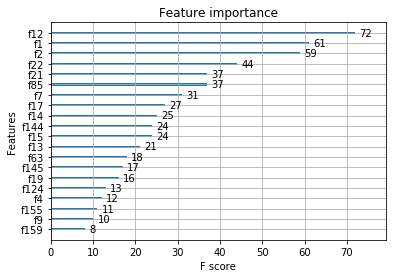

In [205]:
xgb.plot_importance(model1, max_num_features=20)

In [212]:
dtrain = xgb.DMatrix( X1, label=y1)
dtrain.feature_names

NameError: name 'X1' is not defined

In [206]:
training_set_columns = X.columns

In [207]:
training_set_columns[19]

'DAYS_TERMINATION'

In [208]:
most_imp_columns_merge_df = merged_df.groupby(["SK_ID_CURR"])[["DAYS_DECISION", "AMT_PREV_ANNUITY", "EST_PREV_LOAN_PERIOD"
                                                                            , "NAME_CONTRACT_TYPE_Cash loans", "CNT_PAYMENT", "NAME_CLIENT_TYPE_Refreshed", 
                                                                             "DAYS_LAST_DUE_1ST_VERSION", "HOUR_APPR_PROCESS_START", "DAYS_FIRST_DRAWING",
                                                                             "NAME_YIELD_GROUP_low_action", "SELLERPLACE_AREA", "NAME_CONTRACT_STATUS_Unused offer", 
                                                                             "DAYS_TERMINATION"]].mean().reset_index()

In [209]:
most_imp_columns_merge_df.head()

,SK_ID_CURR,DAYS_DECISION,AMT_PREV_ANNUITY,EST_PREV_LOAN_PERIOD,NAME_CONTRACT_TYPE_Cash loans,CNT_PAYMENT,NAME_CLIENT_TYPE_Refreshed,DAYS_LAST_DUE_1ST_VERSION,HOUR_APPR_PROCESS_START,DAYS_FIRST_DRAWING,NAME_YIELD_GROUP_low_action,SELLERPLACE_AREA,NAME_CONTRACT_STATUS_Unused offer,DAYS_TERMINATION
0,100002,-606.000000,9251.775,19.353584,0.000000,24.000000,0.000000,125.000000,9.000000,365243.0,0.0,500.000000,0.0,-17.000000
1,100003,-1305.000000,56553.990,8.677472,0.333333,10.000000,0.666667,-1004.333333,14.666667,365243.0,0.0,533.000000,0.0,-1047.333333
2,100004,-815.000000,5357.250,3.753045,0.000000,4.000000,0.000000,-694.000000,5.000000,365243.0,0.0,30.000000,0.0,-714.000000
3,100006,-272.444444,23651.175,17.767287,0.555556,23.000000,0.000000,91584.000000,14.666667,365243.0,0.0,894.222222,0.0,182481.750000
4,100007,-1222.833333,12278.805,12.644075,0.666667,20.666667,0.000000,-837.200000,12.333333,365243.0,0.0,409.166667,0.0,72143.800000


In [210]:
with open('most_imp_columns_merge_prevapp_df.pkl', 'wb') as picklefile:
    pickle.dump(most_imp_columns_merge_df, picklefile)